# Veto Signalling Loop Attack


In [1]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import project_path  # noqa: F401
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from collections import defaultdict

import experiments.setup  # noqa: F401
from experiments.utils import iterate_simulation_results

In [2]:
current_dir = Path().resolve().parent.parent
out_path = current_dir.joinpath("results/simulations/")
out_path.mkdir(exist_ok=True)

token_distribution_path = current_dir.joinpath("data/stETH_token_distribution.csv")

In [3]:
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

In [4]:
from experiments.templates.withdrawal_queue_replacement import SEED, TIMESTEPS

PRESENTED_RUN = 0
simulation_name = "veto_signalling_loop"
simulation_path = out_path.joinpath(simulation_name)
hashes = [p for p in simulation_path.iterdir() if p.is_dir()]

### Post-processing functions


In [5]:
import time
from experiments.utils import (
    # iterate_simulation_results,
    extract_dg_state_data,
    extract_proposal_data,
    extract_actor_data,
)
from model.utils.postprocessing import postprocessing

dg_state_dfs = []
proposal_dfs = []
actor_dfs = []
post_processing_dfs = []
start = time.time()

for run_df in iterate_simulation_results(simulation_path):
    dg_state_dfs.append(extract_dg_state_data(run_df))
    proposal_dfs.append(extract_proposal_data(run_df))
    actor_dfs.append(extract_actor_data(run_df))
    post_processing_dfs.append(postprocessing(run_df))


dg_state_df = pd.concat(dg_state_dfs, ignore_index=True)
proposal_df = pd.concat(proposal_dfs, ignore_index=True)
actors_df = pd.concat(actor_dfs, ignore_index=True)
post_processing_df = pd.concat(post_processing_dfs, ignore_index=True)

for df in [dg_state_df, proposal_df, actors_df, post_processing_df]:
    df["first_seal_rage_quit_support"] /= 10**16
    df["second_seal_rage_quit_support"] /= 10**16

del dg_state_dfs, proposal_dfs, actor_dfs, post_processing_dfs

print(f"Data loaded in {time.time() - start:.3f} sec")

Data loaded in 7.525 sec


In [6]:
display(post_processing_df)

,dg_state,current_time,total_actors_health,total_contracts_health,total_honest_actors_health,total_attackers_actors_health,total_actors_damaged,total_actors_recovery,total_stETH_balance,total_stETH_locked,...,total_attackers,total_defenders,total_honest_actors_funds,total_attackers_actors_funds,total_defenders_actors_funds,timestep,first_seal_rage_quit_support,second_seal_rage_quit_support,seed,simulation
0,State.Normal,2024-09-01 00:00:00,58640.00,7153.00,58426.00,214.00,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,0,1.00,10.00,188,1
1,State.Normal,2024-09-01 03:00:00,58640.00,7153.00,58426.00,214.00,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,1,1.00,10.00,188,1
2,State.Normal,2024-09-01 06:00:00,76559.00,9415.00,76285.00,274.00,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,2,1.00,10.00,188,1
3,State.Normal,2024-09-01 09:00:00,76559.00,9415.00,76285.00,274.00,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,3,1.00,10.00,188,1
4,State.Normal,2024-09-01 12:00:00,76559.00,9415.00,76285.00,274.00,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,4,1.00,10.00,188,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,State.Normal,2024-11-29 12:00:00,100370.85,12492.38,100016.28,354.56,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,716,1.00,10.00,188,1
717,State.Normal,2024-11-29 15:00:00,100370.85,12492.38,100016.28,354.56,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,717,1.00,10.00,188,1
718,State.Normal,2024-11-29 18:00:00,100370.85,12492.38,100016.28,354.56,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,718,1.00,10.00,188,1
719,State.Normal,2024-11-29 21:00:00,100370.85,12492.38,100016.28,354.56,0,0,4687871.40,0.00,...,4,0,6879096.09,92888.09,0.00,719,1.00,10.00,188,1


### Charts


In [7]:
def create_donut_charts(dataframes, column_names, titles, colors):
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(6 * num_bar_charts, 4))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()
    return fig

In [8]:
def create_donut_charts_2(post_processing_df, donut_charts, monte_carlo_runs, timesteps):
    num_charts_per_run = len(donut_charts)
    fig, axs = plt.subplots(
        monte_carlo_runs, num_charts_per_run, figsize=(6 * num_charts_per_run, 4 * monte_carlo_runs)
    )

    for run in range(monte_carlo_runs):
        start_idx = run * (timesteps + (1 if run > 0 else 0))
        end_idx = start_idx + timesteps

        for i, (labels, sizes, colors, title) in enumerate(donut_charts):
            values = [post_processing_df.loc[end_idx - 1, attr] for attr in sizes]
            total = sum(values)

            if monte_carlo_runs == 1 and num_charts_per_run == 1:
                ax = axs
            elif monte_carlo_runs == 1:
                ax = axs[i]
            else:
                ax = axs[run, i]

            ax.pie(
                values,
                labels=labels,
                colors=colors,
                autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
                startangle=140,
                wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
                textprops=dict(color="black", fontsize=10),
            )
            ax.set_title(title)
            ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()

### Analysis


In [9]:
start_idx = PRESENTED_RUN * (TIMESTEPS + (1 if PRESENTED_RUN > 0 else 0))
end_idx = start_idx + TIMESTEPS

submitted_proposals = post_processing_df.loc[end_idx, "proposals_submitted_count"]
canceled_proposals = post_processing_df.loc[end_idx, "proposals_canceled_count"]
proposals_damage = post_processing_df.loc[end_idx, "total_damage_of_proposals"]
average_damage = post_processing_df.loc[end_idx, "average_damage_per_proposal"]

display(Markdown(f"### Results summary for Monte Carlo Run {PRESENTED_RUN + 1}"))
display(Markdown(f"##### Submitted Proposals: **{submitted_proposals}**"))
display(Markdown(f"##### Canceled Proposals: **{canceled_proposals}**"))
display(Markdown(f"##### Total Damage of Proposals: **{proposals_damage}**"))
display(Markdown(f"##### Average Damage per Proposal: **{average_damage}**"))

### Results summary for Monte Carlo Run 1

##### Submitted Proposals: **1**

##### Canceled Proposals: **0**

##### Total Damage of Proposals: **-15.0**

##### Average Damage per Proposal: **-15.0**

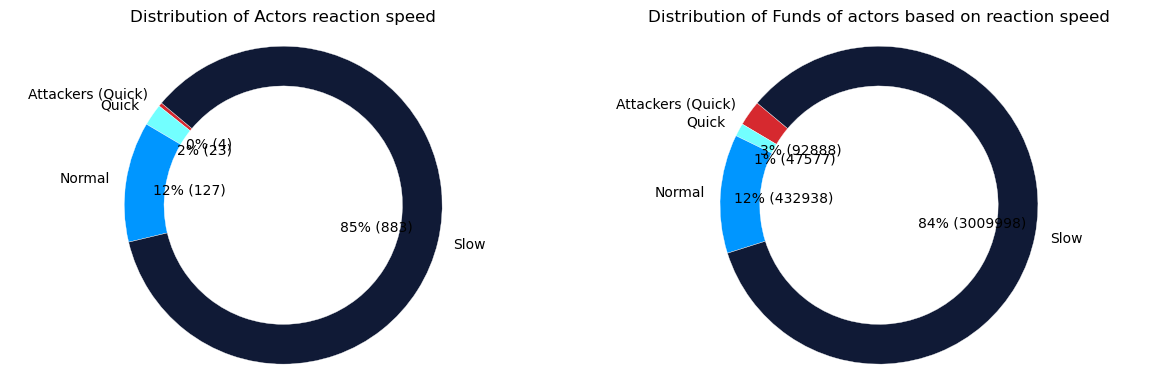

In [10]:
post_processing_df["total_quick_honest_actors_reaction_time"] = (
    post_processing_df["total_quick_actors_reaction_time"] - post_processing_df["total_attackers"]
)
post_processing_df["total_quick_honest_actors_funds"] = (
    post_processing_df["total_quick_actors_funds"] - post_processing_df["total_attackers_actors_funds"]
)


def generate_distribution(post_processing_df, labels, columns, colors, title):
    filtered_labels = []
    filtered_columns = []
    filtered_colors = []

    for label, column, color in zip(labels, columns, colors):
        value = post_processing_df[column]
        if (value != 0).any():
            filtered_labels.append(label)
            filtered_columns.append(column)
            filtered_colors.append(color)

    return (filtered_labels, filtered_columns, filtered_colors, title)


actors_distribution = generate_distribution(
    post_processing_df,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers",
        "total_defenders",
        "total_quick_honest_actors_reaction_time",
        "total_normal_actors_reaction_time",
        "total_slow_actors_reaction_time",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Actors reaction speed",
)

funds_distribution = generate_distribution(
    post_processing_df,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers_actors_funds",
        "total_defenders_actors_funds",
        "total_quick_honest_actors_funds",
        "total_normal_actors_funds",
        "total_slow_actors_funds",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Funds of actors based on reaction speed",
)

## add legend

fig = create_donut_charts_2(post_processing_df, [actors_distribution, funds_distribution], 1, TIMESTEPS)

#### Results Summary for Run 1

##### Time from maximum total health to maximum combined_percentage_locked: **18 hours** (0.75 days)

##### Maximum percentage of rage quit support : **1.33 %**

##### Maximum number of locked tokens : **28081.01 stETH** and **64807.08 wstETH**

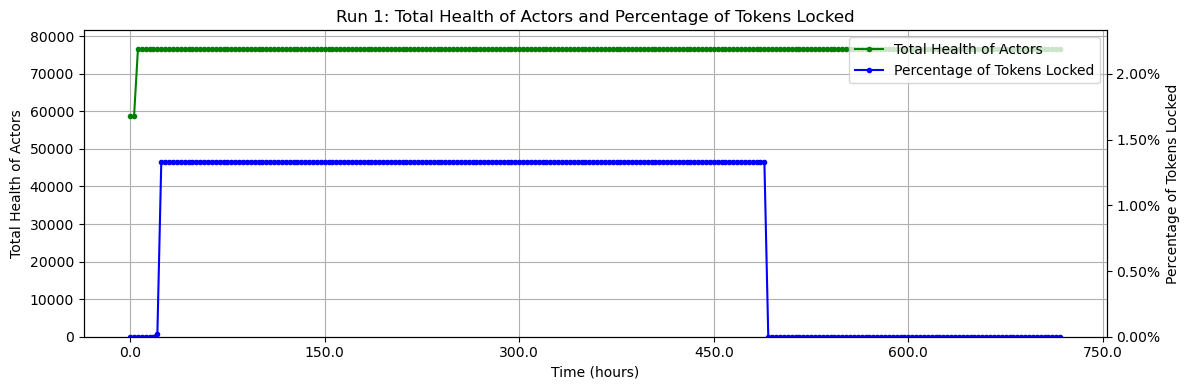

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Markdown, display

start_idx = PRESENTED_RUN * (TIMESTEPS + (1 if PRESENTED_RUN > 0 else 0))
end_idx = start_idx + TIMESTEPS

total_stETH_balance = post_processing_df["total_stETH_balance"].iloc[start_idx:end_idx]
total_stETH_locked = post_processing_df["total_stETH_locked"].iloc[start_idx:end_idx]
total_wstETH_balance = post_processing_df["total_wstETH_balance"].iloc[start_idx:end_idx]
total_wstETH_locked = post_processing_df["total_wstETH_locked"].iloc[start_idx:end_idx]
total_actors_damaged = post_processing_df["total_actors_damaged"].iloc[start_idx:end_idx]
total_actors_health = post_processing_df["total_actors_health"].iloc[start_idx:end_idx]
total_actors_recovery = post_processing_df["total_actors_recovery"].iloc[start_idx:end_idx]
rage_quit_support = post_processing_df["rage_quit_support"].iloc[start_idx:end_idx]
timesteps = post_processing_df["timestep"].iloc[start_idx:end_idx]

combined_balance = total_stETH_balance + total_wstETH_balance + total_stETH_locked + total_wstETH_locked
combined_locked = total_stETH_locked + total_wstETH_locked

percentage_locked = [
    (locked / balance) if balance != 0 else 0 for locked, balance in zip(combined_locked, combined_balance)
]

max_total_health_idx = total_actors_health.idxmax()
max_total_health_ts = timesteps[max_total_health_idx]

max_combined_percentage_locked_idx = percentage_locked.index(max(percentage_locked))
max_combined_percentage_locked_ts = timesteps[start_idx + max_combined_percentage_locked_idx]

time_difference = max_combined_percentage_locked_ts - max_total_health_ts
time_difference_hours = time_difference * 3
time_difference_days = time_difference_hours / 24

display(Markdown(f"#### Results Summary for Run {PRESENTED_RUN + 1}"))
display(
    Markdown(
        f"##### Time from maximum total health to maximum combined_percentage_locked: **{time_difference_hours} hours** ({time_difference_days:.2f} days)"
    )
)
display(Markdown(f"##### Maximum percentage of rage quit support : **{rage_quit_support.max():.2f} %**"))
display(
    Markdown(
        f"##### Maximum number of locked tokens : **{total_stETH_locked.max():.2f} stETH** and **{total_wstETH_locked.max():.2f} wstETH**"
    )
)

fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot total_actors_health on the left y-axis
ax1.plot(timesteps, total_actors_health, color="green", label="Total Health of Actors", marker="o", markersize=3)
max_total_health = total_actors_health.max()
max_total_health_rounded = max_total_health + 5000

ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Total Health of Actors")
ax1.set_ylim(0, max_total_health_rounded)  # Set y-axis limit based on maximum health
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())

# Create a secondary y-axis for percentage_locked
ax2 = ax1.twinx()
ax2.plot(timesteps, percentage_locked, color="blue", label="Percentage of Tokens Locked", marker="o", markersize=3)
ax2.set_ylabel("Percentage of Tokens Locked")

# Calculate the maximum value of percentage_locked and set the y-axis limit
max_percentage_locked = max(percentage_locked)
max_percentage_locked_rounded = max_percentage_locked + 0.01
ax2.set_ylim(0, max_percentage_locked_rounded)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")

ax1.set_title(f"Run {PRESENTED_RUN + 1}: Total Health of Actors and Percentage of Tokens Locked")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

plt.tight_layout()
plt.show()

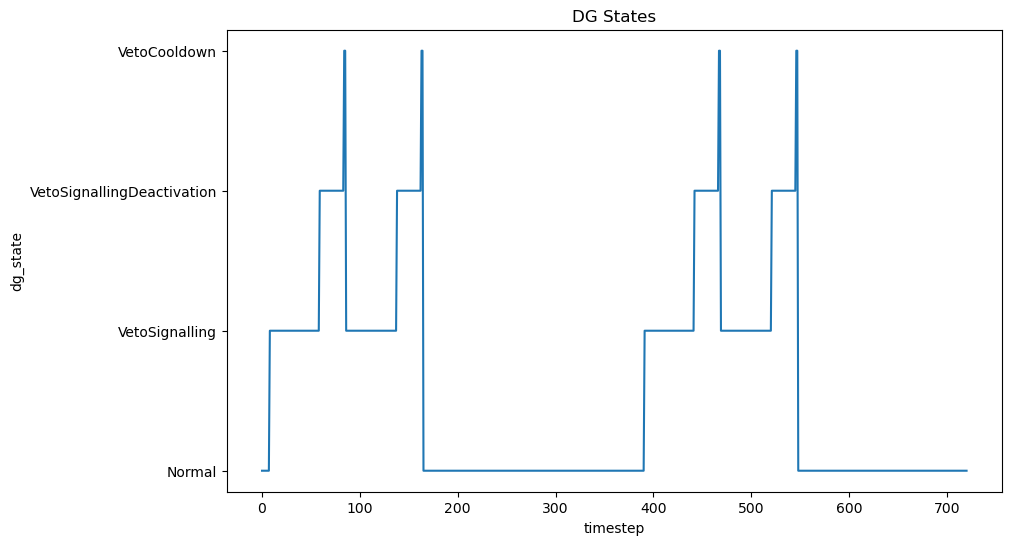

In [12]:
from specs.dual_governance.state import State


def state_plot(df, x, y, run):
    states = df[df.simulation == run][y].map(lambda r: State(r).name)
    plt.figure(figsize=(10, 6))
    plt.plot(df[df.simulation == run][x], states)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("DG States")
    plt.show()


state_plot(post_processing_df, "timestep", "dg_state", 1)